# <center> **Object detection** </center>
## <center> Machine Learning Programming Exercise 10</center>




| <font size=6,font color='red'>Monôme / binôme</font> | <font size=6,font color='red'>Nom</font> | <font size=6,font color='red'>Prénom</font> |
|:-------------: |:----------- |:------ |
| binôme 1 | <span style="color:red">DUBEE</span> | <span style="color:red">Melvin</span> |
| binôme 2 | <span style="color:red">ROUDAUT</span> | <span style="color:red">Tanguy</span> |

Dans ce travail, vous apprendrez à détecter des objets en utilisant le modèle YOLO version 3.

**Vous apprendrez à** :
- Utiliser la détection d'objets sur un jeu de données de détection de voitures ou sur les images de votre choix.
- Traiter les boîtes englobantes et appliquer la procédure d'inférence


# 1. Preamble

## 1.1 Colab or not colab

In [1]:
# common imports
import sys,os,glob

# Colab preamble
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:

  # mount google drive directories
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  # replace the ipynb_name (below) with the name of your jupyter notebook file

  # ----------- Your code here --------------------->

  ipynb_name = 'yolov3_startercode.ipynb'

  # ------------------------------------------------>

  ipynb_name = glob.glob(os.getcwd() + '/gdrive/MyDrive/machine_learning/tp10/' + ipynb_name, recursive = True)
  code_folder = os.path.dirname(ipynb_name[0])

  # change to the right folder
  %cd "$code_folder"
  !ls

  # import special packages for colab
  from google.colab.patches import cv2_imshow


Mounted at /content/gdrive
/content/gdrive/MyDrive/machine_learning/tp10
data  yolov3  yolov3_startercode.ipynb


## 1.2 Import useful packages

In [2]:
# options
# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

# common packages
import numpy as np

# plot packages
# import matplotlib
# matplotlib.use("TkAgg") # permet d'avoir le mode ion sur pycharm

# image proc packages
import cv2
import colorsys


# ml packages
import tensorflow as tf

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IN_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

elif len(tf.config.list_physical_devices('GPU')) > 1:
  # a décommenter si problème avec le GPU de votre machine
  physical_devices = tf.config.experimental.list_physical_devices('GPU')

  for gpu in physical_devices:
      tf.config.experimental.set_memory_growth(gpu, True)

# 2. Position du problème


Vous travaillez sur une voiture à conduite autonome. En tant que composante essentielle de ce projet, vous souhaitez d'abord construire un système de détection des voitures. Pour recueillir des données, vous avez monté une caméra sur le capot (c'est-à-dire à l'avant) de la voiture, qui prend des photos de la route toutes les quelques secondes pendant que vous roulez.


    
<center>
<video width="400" height="200" src="https://drive.google.com/uc?export=view&id=1dvZYjgbkWpOzGMYOtninh22wuaSvU9_T" type="video/mp4" controls>
</video>
    
</center>

Vous avez rassemblé toutes ces images dans un dossier et les avez étiquetées en dessinant des boîtes de délimitation autour de chaque voiture que vous avez trouvée. Voici un exemple de ce à quoi ressemblent vos boîtes englobantes.

Si vous avez 80 classes que vous voulez que YOLO reconnaisse, vous pouvez représenter l'étiquette de classe $c$
- soit sous la forme d'un entier de 1 à 80,
- soit sous la forme `one-hot` d'un vecteur à 80 dimensions (avec 80 nombres) dont une composante est 1 et les autres sont 0.


Dans cet exercice, vous apprendrez comment fonctionne YOLO, puis vous l'appliquerez à la détection de voitures. L'entraînement du modèle YOLO étant très coûteux en termes de calcul, nous chargerons des poids pré-entraînés que vous pourrez utiliser.


# 3. Description de YOLOv3

YOLOv3 ("you only look once") est un algorithme très -populaire parce qu'il atteint une grande précision tout en étant capable de fonctionner en temps réel. Cet algorithme "ne regarde qu'une fois" l'image en ce sens qu'il n'a besoin que d'un seul passage de propagation vers l'avant à travers le réseau pour faire des prédictions. Après une étape de post-processing appelée non-maximal-suppression, il fait des prédictions de présence d'objets dans l'image associée à un boîtes englobante ( appelée par la suite **bbox** pour bounding box aussi appelé anchor box).


## 3.1 - Boites englobantes
Chaque boîte englobante bbox (Figure 1) est représentée par 6 grandeurs $(b_x, b_y, b_h, b_w, p_c, c)$:
 - $b_x, b_y, b_w, b_h$ sont les coordinées, la largeur, la hauteur d'une bbox,
 - $p_c$ est la probabilité de présence d'un objet,
 - $c$ est un vecteur de probabilité de classe à 80 dimensions (encodage `one-hot` pour un apprentissage qui a été fait sur 80 classes possible) ,
 - Chaque bbox est alors representée par 85 nombres.


<center>
<img src="https://drive.google.com/uc?export=view&id=1dxMz5Ci_RASxBTBl5IzTzs9OedxGIFhu" style="width:500px;height:250;"><br>
<caption> <b> Figure 1: Definition des paramètresde la boite englobante</b>  </caption>
</center>


## 3.2 - Entrées, sorties du modèle YOLOv3

Le modèle YOLOv3 est un CNN composé d'un extracteur de features appelé Darknet-53 auquel on a rajouté 3 `têtes` de sortie.

Voici quelques infos sur l'entrée et les sorties du modèle:
- L'**entrée** est un batch (on utilise tensorflow!) de $m$ images de taille ($m$, 416, 416, 3),
- La **sortie** est une **liste de listes de bbox**. Le nombre d'éléments du tuple de sortie est de 3, ce qui équivaut aux possibilités de détection à petite, moyenne et grande échelles de l'algorithme Yolov3. Pour chaque tuple d'échelle, une liste de bbox avec les classes reconnues est produite.

En observant des images dans un contexte de détection d'objets, on peut remarquer que:
- un objet (de la même classe ou de classes différentes) peut être observé à des tailles différentes,
- des objets puissent être localisés à peu près au même endroit dans l'image.

De façon à mieux prendre en compte la différence de taille des objets dans l'image, l'algorithme Yolov3 utilise 3 échelles de détection. Pour chacune des échelles (petite, moyenne, grande), le modèle sort une carte d'activation (i.e. `feature map`) dont la dimension dépend de l'échelle.

De façon à pouvoir détecter la présence d'objets spatialement proche, YOLOv3 predits dans ces échelles des offsets par rapport 3 bbox prédéfinies et de taille différente.

Ainsi, si l'entrée est une image de taille ($m$, 416, 416, 3), la dimension de la sortie pour la:
- petite échelle (facteur de réduction 8) est ($m$, 52, 52, 3, 85)
- échelle moyenne (facteur de réduction 16) est ($m$, 26, 26, 3, 85)
- grande échelle (facteur de réduction 32) est ($m$, 13, 13, 3, 85)

<center>
<img src="https://drive.google.com/uc?id=1nB-K-2tfxWxTx0zVKMBQ2J-pS2B8coEO" style="width:700px;height:400;"><br>
   <caption>
   <b>Figure 2 : Illustration de l'encodage YOLOv3 d'une image pour la grande échelle </b>
    </caption>
</center>

Au final, YOLOv3 analyse (52\*52+26\*26+13\*13)\*3=10647 bbox pour une seule image pour détecter la présence d'object et les classer.



# 4. Tester YOLOv3 avec un modèle préentrainé sur des images

Le but de cette partie est d'appliquer le modèle YOLOv3 préentrainé sur la base d'images [coco](https://cocodataset.org/) sur des images de taille quelconque.

La base d'images [coco](https://cocodataset.org/) regroupe des images de 80 classes:
person, bicycle, car, motorbike, aeroplane, bus, train, truck, boat, traffic light, fire hydrant, stop sign, parking meter, bench, bird, cat, dog, horse, etc.
Les noms des classes sont stockés dans le fichier `coco_classes.txt`.

## 4.1 - Définition des classes

**Question 4.1: Charger les noms des classes à partir du fichier `coco_classes.txt` présent dans le répertoire data.**

In [3]:
# ----------- Your code here --------------------->

class_names = []
with open('./data/coco_classes.txt', 'r') as file:
    for line in file:
        class_names.append(line.strip())

# ------------------------------------------------>
print('nombre de classes dans la base d''images coco: {}'.format(len(class_names)))
print(class_names)



nombre de classes dans la base dimages coco: 80
['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## 4.2 Fonction d'affichage pour l'affichage de bbox

La fonction ci-dessous vous est fournie et vous servira plus tard pour afficher sur une image les bbox.

In [4]:
def draw_bbox(image, bboxes, CLASSES=class_names, show_label=True, show_confidence = True, Text_colors=(255,255,0), rectangle_colors='', tracking=False):
    '''
     image: numpy array
     bboxes: rectangular bbox in a 6D-array with (xmin, ymin, xmax, ymax,score, class_ind) shape
     class_names: list of class_name (string)
    '''

    # local variables
    NUM_CLASS = len(CLASSES)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / NUM_CLASS, 1., 1.) for x in range(NUM_CLASS)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    for i, bbox in enumerate(bboxes):

        # current bbox
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        #  display option
        bbox_color = rectangle_colors if rectangle_colors != '' else colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        if bbox_thick < 1: bbox_thick = 1
        fontScale = 0.75 * bbox_thick

        # put object rectangle on image
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        # put text label on image
        if show_label:
            # get text label
            score_str = " {:.2f}".format(score) if show_confidence else ""

            if tracking: score_str = " "+str(score)

            try:
                label = "{}".format(CLASSES[class_ind]) + score_str
            except KeyError:
                print("You received KeyError, this might be that you are trying to use yolo original weights")
                print("while using custom classes, if using custom model in configs.py set YOLO_CUSTOM_WEIGHTS = True")

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)

    return image


## 4.2 - Création et chargement du modèle préentrainé

Apprendre un modèle YOLOv3 from scratch prend un très long temps et nécessite une grande base de données composée d'images labelisées avec des boites englobantes pour des classes en grand nombre.


**Question 4.2.1: chargez un modèle déjà préentrainé sur la base coco dont les poids sont enregistrés dans le fichier `yolov3.weights` du répertoire data.**

In [5]:
# Taille des images attendues par Yolo
YOLO_INPUT_SIZE = 416

# Chemin vers le fichier contenant les poids préentrainés

# ----------- Your code here --------------------->
YOLO_V3_WEIGHTS = './data/yolov3.weights'

# ------------------------------------------------>

from yolov3.yolov3 import Create_Yolov3
from yolov3.utils import load_yolo_weights

# Création de l'architecture dy modèle darknet 53 x
yolo_model = Create_Yolov3(input_size=YOLO_INPUT_SIZE)

# Création du modèle darknet 53 et chargement des poids préentrainés
load_yolo_weights(yolo_model, YOLO_V3_WEIGHTS)

print('YOLOv3 Model done')



YOLOv3 Model done


**Question 4.2.2: Affichez l'architecture du modèle**

**_`Your commented code below_`**

In [6]:
# ----------- Your code here --------------------->
yolo_model.summary()
# ------------------------------------------------>


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 416, 416, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 416, 416, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 416, 416, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 416, 416, 32)         0         ['batch_normalization[0][0

**Question 4.2.3: A l'aide de texte:**
- **Décrivez l'architecture, cherchez et inclure une image de cette architecture**
- **Donnez le nombre de paramètres entrainable de ce modèle**
- **Trouvez dans le code où $b_x, b_y, b_w, b_h, conf, proba$ sont calculés en sachant que les sorties du réseau ne sont pas exactement $b_x, b_y, b_w, b_h, conf, proba$. Expliquez.**


**_`Double cliquez ici pour écrire votre réponse ici!`_**

<FONT COLOR="#ff0000">

**Solution**
- CNN: darknet avec 3 tetes de sortie des sous-échantillonnge 8,16,32
- sorties en fait $t_x, t_y, t_w, t_h$
- $b_x, b_y, b_w, b_h, conf, proba$ calculés dans yolov3.decode
- Total params: 62,001,757
- Trainable params: 61,949,149
- Non-trainable params: 52,608
</FONT>


## 4.3 - Chargement d'une image avec opencv

In [7]:
image_path   = "data/soireefoyz-bar.jpg"
original_image  = cv2.imread(image_path)
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)


**Display the image**

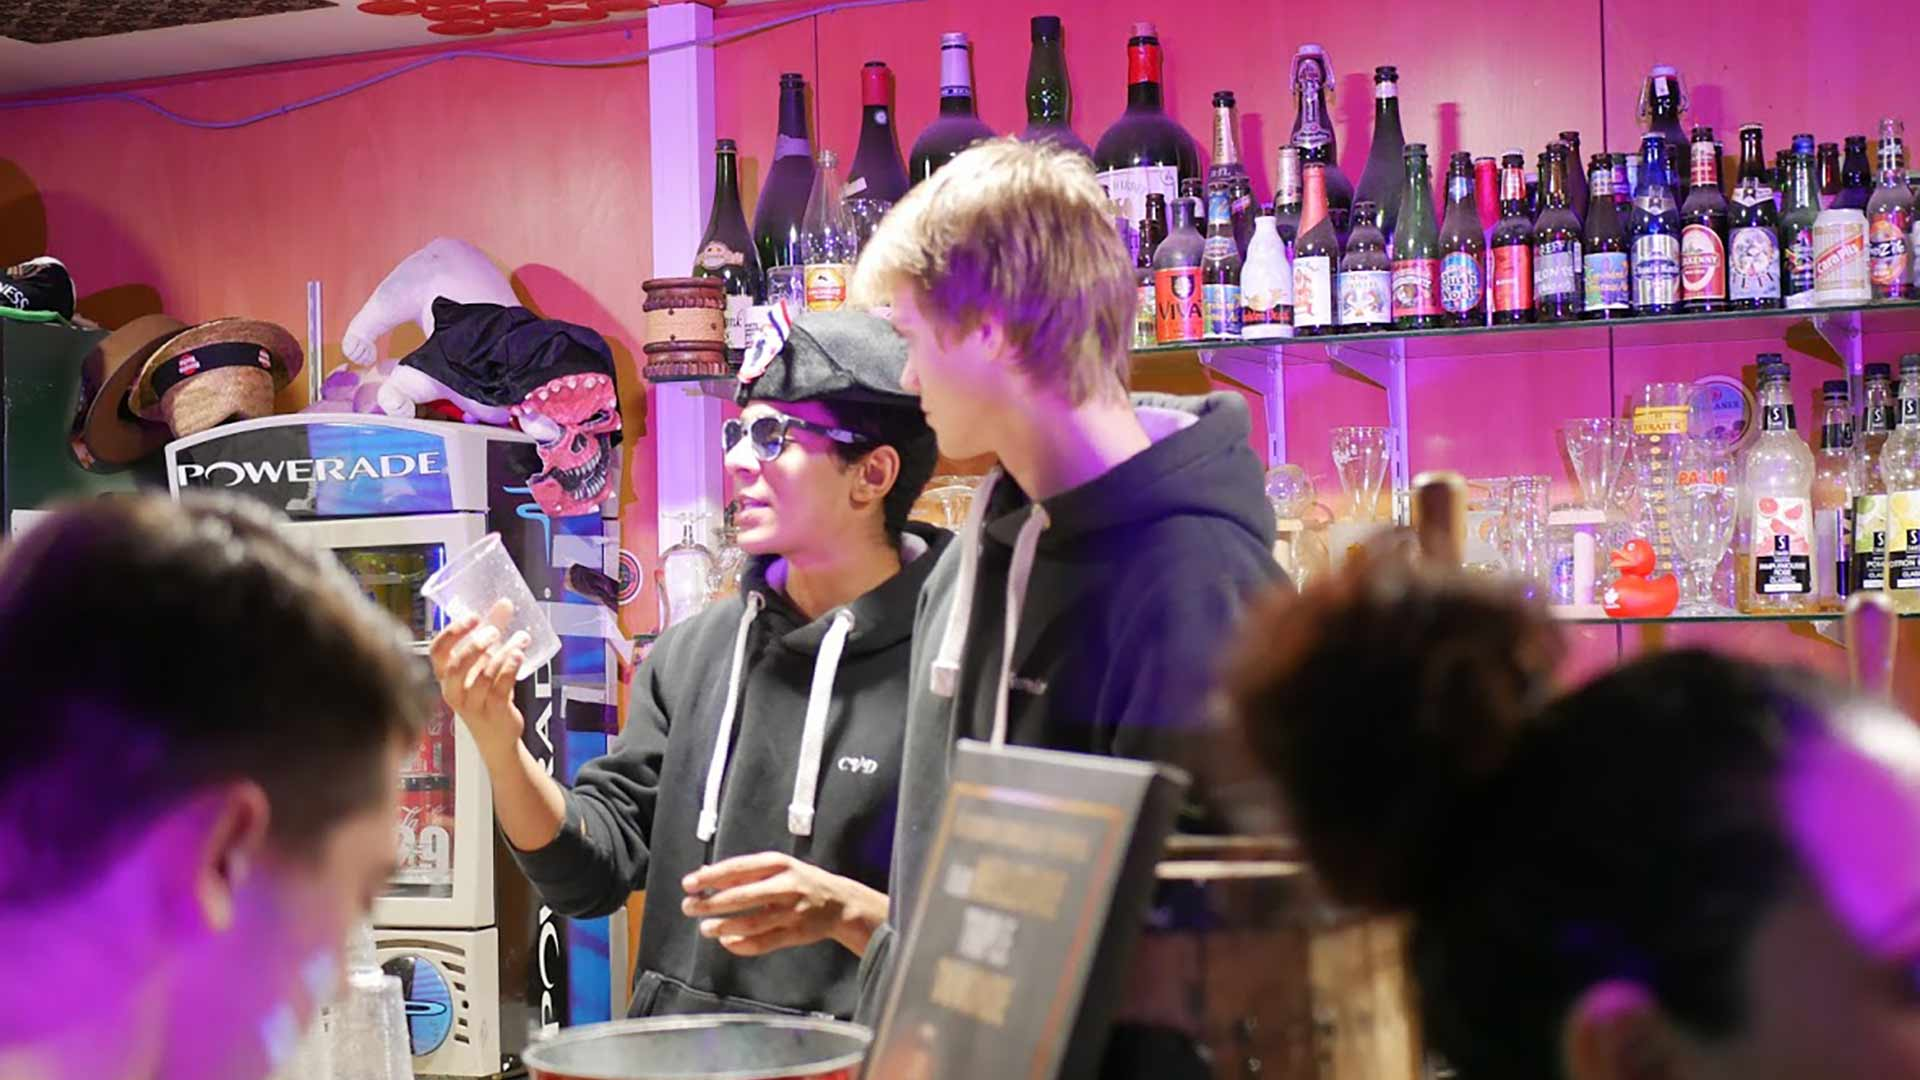

In [8]:
if IN_COLAB:
    cv2_imshow(cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))
else:
    cv2.imshow("original image", cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR))
    # Load and hold the image
    cv2.waitKey(0)

    # To close the window after the required kill value was provided
    cv2.destroyAllWindows()


## 4.4 - Appliquer le modèle YOLOv3 à l'image


### 4.4.1 - Prétraitements de l'image

Le modèle YOLOv3 attend des images par batch ($m$, 416,416,3) en entrée. Il faut donc les transformer (réduire) à la taille adéquate en gardant le rapport hauteur/largeur. Il s'agit donc de:
- déterminer le coefficient d'échelle pour réduire l'image originale
- effectuer la réduction avec la fonction `resize` d'opencv
- rajouter des pixels factices de valeurs  (128.0) pour compléter une image finale de 416x416

**Question 4.4.1.1: compléter le code ci-dessous pour réaliser ces étapes**

In [9]:
yolo_h, yolo_w      = [YOLO_INPUT_SIZE,YOLO_INPUT_SIZE]
orig_h,  orig_w, _  = original_image.shape

# ----------- Your code here --------------------->
# déterminer le coefficient d'échelle pour réduire l'image originale


resize_ratio = min(YOLO_INPUT_SIZE / orig_h, YOLO_INPUT_SIZE / orig_w)
new_w = int(orig_w * resize_ratio)
new_h = int(orig_h * resize_ratio)


# ------------------------------------------------>


# ----------- Your code here --------------------->
# effectuer la réduction avec la fonction `resize` d'opencv

resized_image = cv2.resize(original_image, (new_w, new_h))

# ------------------------------------------------>



# ----------- Your code here --------------------->
# créez une image de la taille finale 416x416
# insérez l'image réduite
# rajouter des pixels factices de valeurs  (128.0) pour compléter une image finale de 416x416

yolo_image = np.full((YOLO_INPUT_SIZE, YOLO_INPUT_SIZE, 3), 128.0, dtype=np.uint8)
diff_w = (YOLO_INPUT_SIZE - new_w) // 2
diff_h = (YOLO_INPUT_SIZE - new_h) // 2
yolo_image[diff_h:new_h + diff_h, diff_w:new_w + diff_w] = resized_image


# ------------------------------------------------>


**Question 4.4.1.2: formez un batch d'images à une seule image normalisez entre [0,1] de type float32**

In [10]:
# ----------- Your code here --------------------->
# normalisez l'image strictement entre 0 et 1

yolo_image = yolo_image / 255.0

# ------------------------------------------------>




# ----------- Your code here --------------------->
# Rajout (np.newaxis) de la dimension batch à l'image avant car les modèles tensorflow le nécessitent

yolo_image = yolo_image[np.newaxis, ...]

# ------------------------------------------------>


# on assure le type float32
yolo_image = yolo_image.astype(np.float32)


**Question 4.4.1.3: Pourquoi doit-on faire cela?**


**_`Double cliquez ici pour écrire votre réponse ici!`_**

<FONT COLOR="#ff0000">

**Solution**
- Normalisation pour rentrer dans un réseau de neurones, pour suivre le modèle YOLOv3
- Dimension batch à rajouter pour pouvoir utiliser tensorflow (pas moins de 4D)
- float32 pour les calculs dans tensorflow

</FONT>


**Afficher l'image résultante**

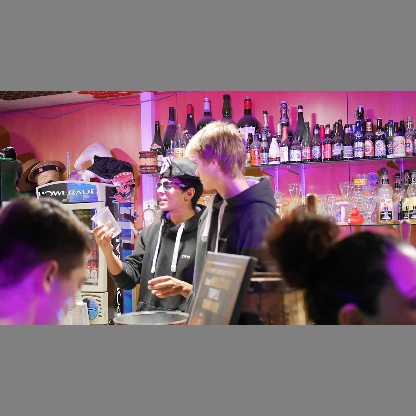

In [11]:
# Google colab nécessite une fonction spéciale pour l'affichage
if IN_COLAB:
  cv2_imshow(cv2.cvtColor(yolo_image[0,...]*255, cv2.COLOR_RGB2BGR))
else:

  cv2.imshow("Image réduite et avec rajout de valeurs", cv2.cvtColor(yolo_image[0,...], cv2.COLOR_RGB2BGR))
  cv2.waitKey(0)

  cv2.destroyAllWindows()


### 4.4.2 - Appliquer le modèle YOLOv3 (forward propagation)

**Question 4.4.2.1: réaliser le code correspondant**

**Attention: deux techniques sont possibiles avec tensorflow: mettre l'image en entrée du modèle ou utiliser la méthode 'predict' du modèle. Malheureusement, ces deux techniques ne sortent pas la même objet. Attention!**

In [12]:
# ----------- Your code here --------------------->

# Utilisation de la méthode directe
# bbox_pred = yolo_model(yolo_image)

# Ußtilisation de la méthode 'predict'
bbox_pred = yolo_model.predict(yolo_image)

# ------------------------------------------------>

print('Predictions done')
print('Dimensions de bbox_pred:')
print([bbox.shape for bbox in bbox_pred])


1/1 [==============================] - 6s 6s/step
Predictions done
Dimensions de bbox_pred:
[(1, 52, 52, 3, 85), (1, 26, 26, 3, 85), (1, 13, 13, 3, 85)]


**Question 4.4.2.2: Décrire tous les éléments de la variable `bbox_pred`. A quoi cela correspond?**


**_Your commented code below_**

In [13]:
# ----------- Your code here --------------------->

print('Sorties:')
print('small scale: {}'.format(bbox_pred[0].shape))
print('medium scale: {}'.format(bbox_pred[1].shape))
print('large scale: {}'.format(bbox_pred[2].shape))

# ------------------------------------------------>

Sorties:
small scale: (1, 52, 52, 3, 85)
medium scale: (1, 26, 26, 3, 85)
large scale: (1, 13, 13, 3, 85)


**_Double cliquez ici pour écrire votre réponse ici!_**

<FONT COLOR="#ff0000">

**Solution**
Liste de 3 tenseurs liés aux 3 échelles:
- small scale: 1 batch, grilles de 52x52, 3 bboxes, 85 paramètres: 4 de position, 1 objectness, 80 classes
- medium scale : 1 batch, grilles de 26x26, 3 bboxes, 85 paramètres: 4 de position, 1 objectness, 80 classes
- large scale : 1 batch, grilles de 13x13, 3 bboxes, 85 paramètres: 4 de position, 1 objectness, 80 classes
    
</FONT>


## 4.5 - Post traitement des sorties



### 4.5.1 - Mise en forme de `bbox_pred`


Nous allons réaliser ces post-traitement en numpy

In [14]:
bbox_pred = [np.array(x) for x in bbox_pred]

Il est temps d'implémenter une fonction prenant la sortie du CNN profond (l'encodage dimensionnel [[52x52x3x85], [26x26x3x85], [13x13x3x85]]) remodelé comme un tenseur [10647x85] avec toutes les bbox avant de  filtrer des bbox .


**Question 4.5.1.1. Ecrire un code permettant:**
- **de mettre en forme 'bbox_pred' en 2D avec 1 bbox par ligne et 85 descripteurs en colonne**
- **séparer les colonnes de 'bbox_pred' en 3 matrices correspondant à xywh, conf (confidence score, objectness) et prob (probabilité de chaque porentiel objet/classe)**

In [15]:
# ----------- Your code here --------------------->
# mettre en forme 'bbox_pred' en 2D avec 1 bbox par ligne et 85 descripteurs en colonne (tensor shape of 10647x85)

bbox_pred = np.concatenate([bbox.reshape(-1, 85) for bbox in bbox_pred], axis=0)

# ------------------------------------------------>
print('bbox_pred: {}'.format(bbox_pred.shape))



# ----------- Your code here --------------------->
# séparer les informations de bbox_pred

bbox_pred_xywh = bbox_pred[:, :4]
bbox_pred_conf = bbox_pred[:, 4:5]
bbox_pred_prob = bbox_pred[:, 5:]

# ------------------------------------------------>




bbox_pred: (10647, 85)


### 4.5.2 - Traitements des positions de `bbox_pred`

**Question 4.5.2.1: Ecrire un code permettant de calculer xmin, ymin, xmax, ymax (nécessaire en particulier à `draw_bbox`) et de les mettre dans une matrice 10647 lignes et 4 colonnes**

In [16]:
# ----------- Your code here --------------------->
# convert (x, y, w, h) --> bbox_pred_coor = (xmin, ymin, xmax, ymax)

x, y, w, h = bbox_pred_xywh[:, 0], bbox_pred_xywh[:, 1], bbox_pred_xywh[:, 2], bbox_pred_xywh[:, 3]
xmin = x - w / 2
ymin = y - h / 2
xmax = x + w / 2
ymax = y + h / 2

bbox_pred_coor = np.stack([xmin, ymin, xmax, ymax], axis=1)
# ------------------------------------------------>

print(bbox_pred_coor.shape)



(10647, 4)


**Question 4.5.2.2. Ecrire un code permettant de transformer les coordonnées (xmin, ymin, xmax, ymax) des bbox de l'image liées aux dimensions 416x416 vers les coordonnées liées la taille de l'image originale**



In [17]:
# **Attention**: Les coordonnées de la bbox à ce stade sont référencées par rapport à des dimensions 416x416.
# Lors de la mise à cette dimension de l'image, pour garder le rapport h/w de l'image, il a fallu rajouter des lignes
# et des colonnes (padding). Il s'agit donc ici de coder la transformation dans l'ordre inverse:
# - se ramener aux coordonnées avant padding
# - appliquer le rapport de dimensions


# ----------- Your code here --------------------->

# - se ramener aux coordonnées avant padding
bbox_pred_coor[:, 0] -= diff_w  # xmin
bbox_pred_coor[:, 2] -= diff_w  # xmax
bbox_pred_coor[:, 1] -= diff_h  # ymin
bbox_pred_coor[:, 3] -= diff_h  # ymax

# - appliquer le rapport de dimensions
bbox_pred_coor[:, 0] = bbox_pred_coor[:, 0] / resize_ratio  # xmin
bbox_pred_coor[:, 2] = bbox_pred_coor[:, 2] / resize_ratio  # xmax
bbox_pred_coor[:, 1] = bbox_pred_coor[:, 1] / resize_ratio  # ymin
bbox_pred_coor[:, 3] = bbox_pred_coor[:, 3] / resize_ratio  # ymax

bbox_pred_coor = np.clip(bbox_pred_coor, a_min=0, a_max=[orig_w, orig_h, orig_w, orig_h])
# ------------------------------------------------>




### 4.5.3 - Traitements des scores de `bbox_pred`

**Question 4.5.3.1: Ecrire un code permettant de:**
- **d'extraire l'indice `bbox_pred_class` et la probabilité `bbox_pred_class_prob` de la classe prédite pour chaque bbox**
- **de calculer le score `bbox_pred_score` pour chaque bbox définit par:**

**\begin{align*}
	bbox\_pred\_score &= P[\text{object in img}] \times \max_i{P[c_i|\text{object in img}]}
\end{align*}**

In [18]:
# ----------- Your code here --------------------->
#  extraire l'indice bbox_pred_class et la probabilité max bbox_pred_class_prob de la classe prédite pour chaque bbox

bbox_pred_class = np.argmax(bbox_pred_prob, axis=1)
bbox_pred_class_prob = np.max(bbox_pred_prob, axis=1)

# ------------------------------------------------>





# ----------- Your code here --------------------->
# calculer le score `bbox_pred_score` pour chaque bbox (cf slide 36 boxes_score)

bbox_pred_score = bbox_pred_conf.flatten() * bbox_pred_class_prob

# ------------------------------------------------>



Les lignes suivantes permettent d'afficher les résultats de prédiction.


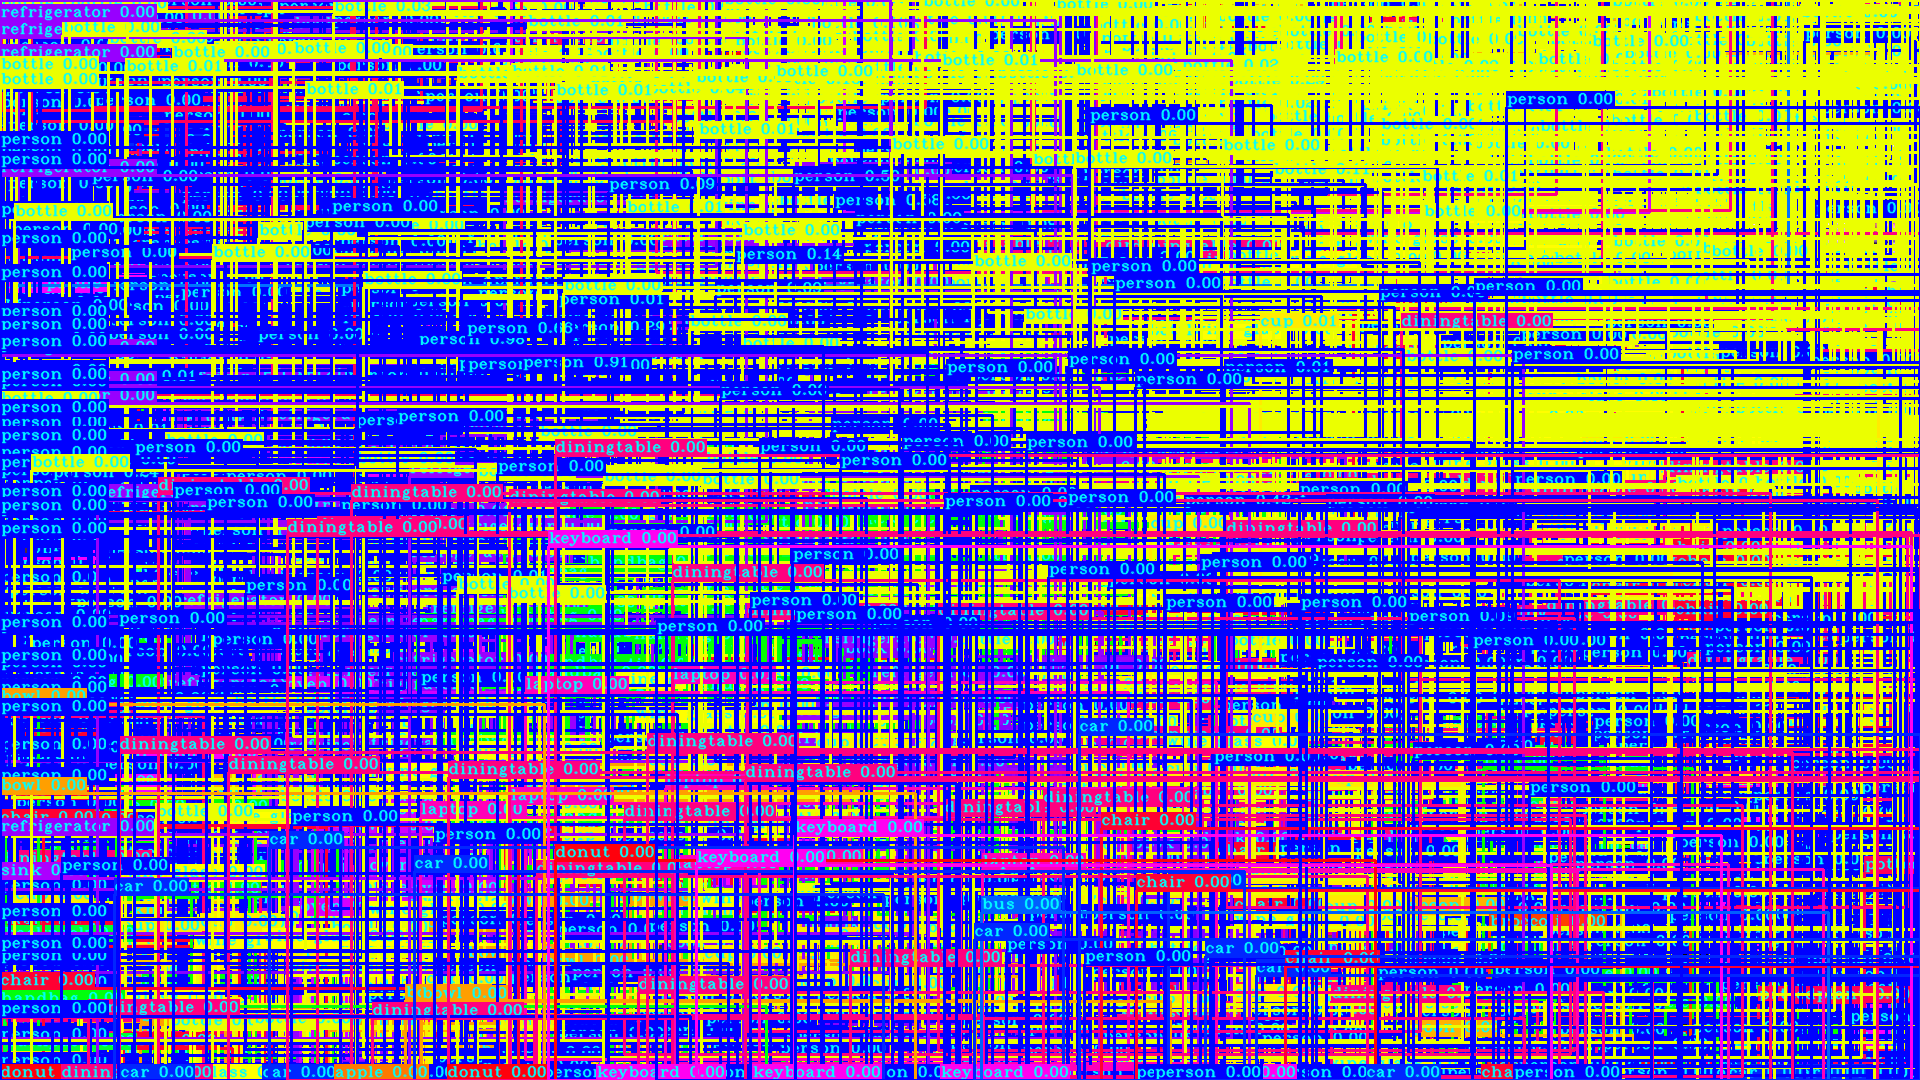

In [19]:
bbox_pred_tmp = np.concatenate([bbox_pred_coor,
                            bbox_pred_score[:, np.newaxis],
                            bbox_pred_class[:, np.newaxis]], axis=-1)

bbox_pred_tmp = np.array(bbox_pred_tmp)


img = draw_bbox(cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR), bbox_pred_tmp, CLASSES=class_names)

if IN_COLAB:
  cv2_imshow(img)
else:
  cv2.imshow("image with detected objects", img)
  # Load and hold the image
  cv2.waitKey(0)
  cv2.destroyAllWindows()


**Question 4.5.3.2: Conclusion?**

**_Double cliquez ici pour écrire votre réponse ici!_**

<FONT COLOR="#ff0000">

**Solution**
Il faut filtrer    
           
</FONT>


## 4.6 - Filtrage des `bbox`
Il s'agit maintenant après tout ce travail préliminaire de filtrer les bbox à l'aide de maques permettant de sélectionner uniquement les meilleures. 3 étapes de filtrages vont être réalisées:


##### 4.6.1 - Masque (matrice booléenne) de filtrage des `bbox` de coordonnées erronnées

**Question 4.6.1.1: Ecrire un code permettant d'obtenir un masque booléen (ou les indices correspondant aux `true`) tel que masque = 1:**
- **si xmin,ymin >= 0**
- **si xmax,ymax  <= tailles de l'image originale**
- **et que xmin < xmax**
- **et que ymin < ymax**

Indication: `np.logical_and`



In [20]:
# ----------- Your code here --------------------->
# clip some boxes those are out of range

xmin, ymin, xmax, ymax = bbox_pred_coor[:, 0], bbox_pred_coor[:, 1], bbox_pred_coor[:, 2], bbox_pred_coor[:, 3]

cond1 = np.logical_and(xmin >= 0, ymin >= 0)
cond2 = np.logical_and(xmax <= orig_w, ymax <= orig_h)
cond3 = np.logical_and(xmin < xmax, ymin < ymax)

bbox_pred_valid_range_mask = np.logical_and(np.logical_and(cond1, cond2), cond3)

# ------------------------------------------------>
print('Pourcentage de bboxes garder: {}'.format(np.sum(bbox_pred_valid_range_mask)/bbox_pred_valid_range_mask.shape[0]))
print('Expected values: 0.64778811')



Pourcentage de bboxes garder: 0.6485394946933408
Expected values: 0.64778811


### 4.6.2 - Filtrage des `bbox` avec peu de confiance dans la présence d'un objet
**Question: Ecrire un code permettant d'obtenir un masque booléen (ou les indices correspondant aux `true`) tel que masque = 1 si `box_score > BOX_SCORE_THRESHOLD`**


In [21]:
BOX_SCORE_THRESHOLD = 0.3

# ----------- Your code here --------------------->
# discard boxes with low scores
# Créer un masuqe de filtrage basé syr kes scores et en utilisant le seuil ci-dessus.

bbox_pred_valid_score_mask = bbox_pred_score > BOX_SCORE_THRESHOLD

# ------------------------------------------------>

print('Pourcentage de bbox garder: {}'.format(np.sum(bbox_pred_valid_score_mask)/bbox_pred_valid_score_mask.shape[0]))
print('Expected values: 0.00638678')

Pourcentage de bbox garder: 0.0063867756175448485
Expected values: 0.00638678


### 4.6.3 - Filtrage des `bbox` avec les masques de filtrage


In [22]:

# ----------- Your code here --------------------->
# Appliquer les masques to scores, boxes and classes

mask = np.logical_and(bbox_pred_valid_range_mask, bbox_pred_valid_score_mask)
bbox_pred_coor = bbox_pred_coor[mask]
bbox_pred_score = bbox_pred_score[mask]
bbox_pred_class = bbox_pred_class[mask]

# ------------------------------------------------>






# ----------- Your code here --------------------->
# Filtrage et reconstruction de bbox_pred

bbox_pred = np.concatenate([bbox_pred_coor, bbox_pred_score[:, np.newaxis], bbox_pred_class[:, np.newaxis]], axis=1)

# ------------------------------------------------>



### 4.6.3 - Filtrage des `bbox` trop proches spatialement pour le même objet (Non-Max-Supression)

Même après un filtrage par seuillage sur les scores des classes, on se retrouve avec un grand nombre de boîtes qui se chevauchent (Figure 2).
<center>
<img src="https://drive.google.com/uc?id=1szJubhI0n1dYLAZH5dyHe3MhJ4cRjDM3" style="width:500px;height:400;"><br>
<caption> <b> Figure 3: Dans cet exemple, le modèle a prédit la présence de 3 voitures, mais il s'agit en fait de 3 prédictions de la même voiture. L'exécution de la suppression non maximale (NMS) sélectionnera uniquement la plus précise (probabilité la plus élevée) des 3 boîtes. </b> </caption>
</center>

Un deuxième filtre pour sélectionner les bonnes boîtes est appelé suppression non maximale (NMS). Ce filtre sélectionnera une seule bbox lorsque plusieurs bbox se chevauchent et détectent le même objet.

#### 4.6.3.1 - Préambule: Intersection over Union (IoU)

Nous allons ici définir le moyen de quantifier le chevauchement de deux bbox par une métrique appelée Intersection over Union (IoU).

<center>
<img src="https://drive.google.com/uc?id=1Li2JQY4bHLRVytQcV-iTxJaZ7v0HgNCB" style="width:500px;height:400;">
<caption> <b> Figure 4 : Definition de l'"Intersection over Union". </br> </caption>
</center>


**Question: Ecrire le code permettant d'implémenter la fonction `cpt_bbox_iou` **

**_`Your commented code below`_**

In [23]:
def cpt_bbox_iou(boxes1, boxes2):

    """Implement the intersection over union (IoU) between box1 and box2

    Arguments:
    boxes1 -- first box, list object with coordinates (x1, y1, w1, h1)
    boxes2 -- second box, list object with coordinates (x2, y2, w2, h2)
    """

    # Guaranti d'avoir du numpy array
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    # Calculer les coordonnéees de l'intersection des box1 and box2. Calculer sa surface.
    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])
    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]

    # ----------- Your code here (≈ 3 lines) --------------------->
    # Calculer la surface de l'union par la formule: Union(A,B) = A + B - Inter(A,B)

    boxes1_area = boxes1[..., 2] * boxes1[..., 3]
    boxes2_area = boxes2[..., 2] * boxes2[..., 3]
    union_area = boxes1_area + boxes2_area - inter_area

    # ------------------------------------------------------------>





    # ----------- Your code here (≈ 1 lines) --------------------->
    # Calculer l' IoU

    iou = inter_area / union_area

    # ------------------------------------------------------------>


    # éviter les 0s
    ious = np.maximum(iou, np.finfo(np.float32).eps)

    return ious



**Test de la fonction**

In [24]:
box1 = np.array((2., 1., 4., 3.))
box2 = np.array((1., 2., 3., 4.))
a = cpt_bbox_iou(box1, box2)
print("iou = ", a)

iou =  0.043478260869565216


**Expected Output**:

<table>
    <tr>
        <td>
            **iou = **
        </td>
        <td>
           0.14285714285714285
        </td>
    </tr>

</table>

#### 4.6.3.2 -  Non-Max-Suppression

Vous êtes maintenant prêt à mettre en œuvre l'algorithme NMS. Il s'agit d'un algorithme itératif dontes étapes clés sont les suivantes :
1. Sélectionnez toutes les bbox prédisants une classe particulière
2. Sélectionnez celle qui a le score le plus élevé.
3. Calculez son chevauchement avec les autres bbox, et supprimez les bbox dont le chevauchement est supérieur à `IOU_THRESHOLD`.
4. Retournez à l'étape 1 et itérez jusqu'à ce qu'il n'y ait plus de bbox avec un score inférieur à celui de la boîte sélectionnée.

Ceci éliminera toutes les bbox qui ont un grand chevauchement avec les bbox sélectionnées. Il ne reste que les "meilleures" bbox.

**Question** : Complétez le code suivant


In [25]:
# L'algorithme NMS est ainsi:
# boucles sur les classes prédites
    # etape 1: selectionner les bboxes de la classe prédite courante (cls_bboxes)
    # Tant que cette liste de bboxes (cls_bboxes) n'est pas vide
        # Etape 2: selectionner la bbox 'best_bbox' avec le plus haut score dans cls_bboxes et la mettre dans la liste des bboxes finales best_bboxes et l'enlever de la liste cls_bboxes
        # Etape 3: calculer l'IoU entre best_bbox et cls_bboxes
        # Etape 4: Toutes les bboxes de cls_bboxes ayant un \textbf{chevauchement (IoU) supérieur à un seuil prédéfini IOU_THRESHOLD(souvent 0.45)} avec la box best_bbox sont éliminées de cls_bboxes


# indices de classe prédits dans l'images
classes_in_img = list(set(bbox_pred[:, 5]))


# ----------- Your code here --------------------->
IOU_THRESHOLD = 0.5
best_bboxes = []

for cls in classes_in_img:
    # etape 1: selectionner les bboxes de la classe prédite courante (cls_bboxes)
    cls_indices = np.where(bbox_pred[:, 5] == cls)[0]
    cls_bboxes = bbox_pred[cls_indices]

    # Tant que cette liste de bboxes (cls_bboxes) n'est pas vide
    while len(cls_bboxes) > 0:
        # Etape 2: selectionner la bbox 'best_bbox' avec le plus haut score dans cls_bboxes et la mettre dans la liste des bboxes finales best_bboxes et l'enlever de la liste cls_bboxes
        best_bbox_index = np.argmax(cls_bboxes[:, 4])
        best_bbox = cls_bboxes[best_bbox_index]
        best_bboxes.append(best_bbox)
        cls_bboxes = np.delete(cls_bboxes, best_bbox_index, axis=0)

        if len(cls_bboxes) == 0:
            break

        # Etape 3: Calculer l'IoU entre best_bbox et cls_bboxes
        ious = np.array([cpt_bbox_iou(best_bbox[:4], bbox[:4]) for bbox in cls_bboxes])

        # Etape 4: Toutes les bboxes de cls_bboxes ayant un \textbf{chevauchement (IoU) supérieur à un seuil prédéfini IOU_THRESHOLD(souvent 0.45)} avec la box best_bbox sont éliminées de cls_bboxes
        cls_bboxes = cls_bboxes[ious <= IOU_THRESHOLD]

best_bboxes = np.array(best_bboxes)


# ------------------------------------------------>
print('Nombre de bboxes conservées: {}'.format(len(best_bboxes)))
print('Valeur attendue: 35')



Nombre de bboxes conservées: 68
Valeur attendue: 35


**Question: Afficher toutes les bboxes prédites sur l'image à l'aide de draw_bbox**

**_`Your commented code below`_**

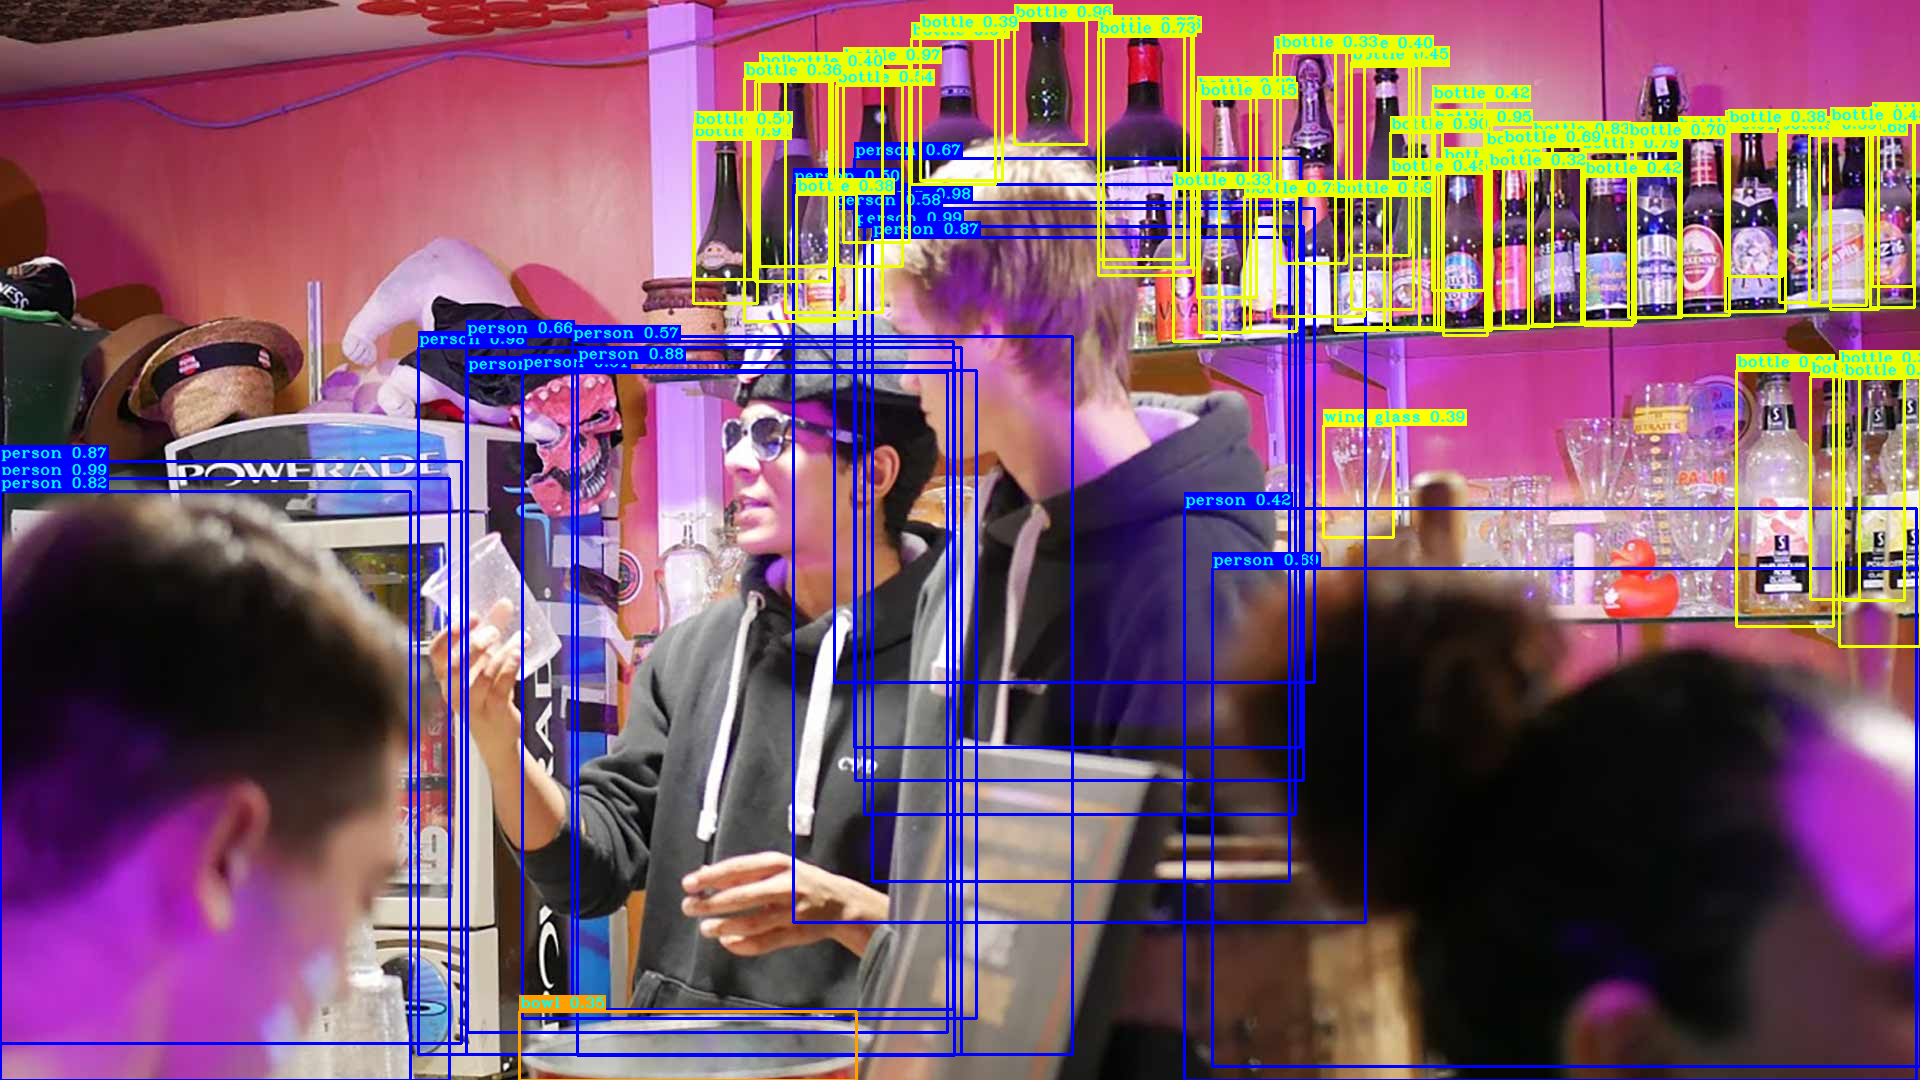

In [26]:
best_bboxes = np.array(best_bboxes)


img = draw_bbox(cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR), best_bboxes, CLASSES=class_names)

if IN_COLAB:
  cv2_imshow(img)
else:
  cv2.imshow("image with detected objects", img)
  # Load and hold the image
  cv2.waitKey(0)
  cv2.destroyAllWindows()



**Question: Créer une image représentant un diagramme concernant le processus utilisé par YOLOv3 pour détecter et localiser des objets dans une image**


**_`Double cliquez ici pour insérer votre image ici!`_**


# 5. Tester YOLOv3 avec un modèle préentrainé pour la détection d'objects d'une voiture robot


**Question: Créer scripts et fonctions permettant de lire, prédire et sauver les prédictions du répertoire drive**

**Indication:**
image_path = "./data/drive/*.jpg"
img_array = []
for name in glob.glob(image_path):

  # chargement
  original_image = cv2.imread(name)
  original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

  ...# pretraiter, predire, post traiter, inscriver les boites dans l'image courante

  img_array.append(img_with_bboxes)


# sauver les images dans un fichier .avi
out = cv2.VideoWriter('detectcar.avi', cv2.VideoWriter_fourcc(*'DIVX'), 1, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()



In [27]:
def preprocess_input(img):
    yolo_h, yolo_w      = [YOLO_INPUT_SIZE, YOLO_INPUT_SIZE]
    orig_h,  orig_w, _  = img.shape

    resize_ratio = min(YOLO_INPUT_SIZE / orig_h, YOLO_INPUT_SIZE / orig_w)
    new_w = int(orig_w * resize_ratio)
    new_h = int(orig_h * resize_ratio)

    resized_image = cv2.resize(img, (new_w, new_h))

    yolo_image = np.full((YOLO_INPUT_SIZE, YOLO_INPUT_SIZE, 3), 128.0, dtype=np.uint8)
    diff_w = (YOLO_INPUT_SIZE - new_w) // 2
    diff_h = (YOLO_INPUT_SIZE - new_h) // 2
    yolo_image[diff_h:new_h + diff_h, diff_w:new_w + diff_w] = resized_image

    yolo_image = yolo_image / 255.0
    yolo_image = yolo_image[np.newaxis, ...]
    yolo_image = yolo_image.astype(np.float32)

    return yolo_image, resize_ratio, orig_w, orig_h, diff_w, diff_h

def bbox_pred_shape_formatting(bbox_pred):
    bbox_pred = [np.array(x) for x in bbox_pred]
    bbox_pred = np.concatenate([bbox.reshape(-1, 85) for bbox in bbox_pred], axis=0)
    bbox_pred_xywh = bbox_pred[:, :4]
    bbox_pred_conf = bbox_pred[:, 4:5]
    bbox_pred_prob = bbox_pred[:, 5:]

    return bbox_pred_xywh, bbox_pred_conf, bbox_pred_prob

def bbox_pred_position_formating(bbox_pred_xywh, bbox_pred_conf, bbox_pred_prob, resize_ratio, orig_w, orig_h, diff_w, diff_h):
    x, y, w, h = bbox_pred_xywh[:, 0], bbox_pred_xywh[:, 1], bbox_pred_xywh[:, 2], bbox_pred_xywh[:, 3]
    xmin = x - w / 2
    ymin = y - h / 2
    xmax = x + w / 2
    ymax = y + h / 2
    bbox_pred_coor = np.stack([xmin, ymin, xmax, ymax], axis=1)

    bbox_pred_coor[:, 0] -= diff_w
    bbox_pred_coor[:, 2] -= diff_w
    bbox_pred_coor[:, 1] -= diff_h
    bbox_pred_coor[:, 3] -= diff_h

    bbox_pred_coor[:, 0] = bbox_pred_coor[:, 0] / resize_ratio
    bbox_pred_coor[:, 2] = bbox_pred_coor[:, 2] / resize_ratio
    bbox_pred_coor[:, 1] = bbox_pred_coor[:, 1] / resize_ratio
    bbox_pred_coor[:, 3] = bbox_pred_coor[:, 3] / resize_ratio

    bbox_pred_coor = np.clip(bbox_pred_coor, a_min=0, a_max=[orig_w, orig_h, orig_w, orig_h])

    return bbox_pred_coor

def processing_bbox_scrore(bbox_pred_prob, bbox_pred_conf):
    bbox_pred_class = np.argmax(bbox_pred_prob, axis=1)
    bbox_pred_class_prob = np.max(bbox_pred_prob, axis=1)
    bbox_pred_score = bbox_pred_conf.flatten() * bbox_pred_class_prob

    return bbox_pred_score, bbox_pred_class


def boolean_mask_filtering(bbox_pred_coor, bbox_pred_score, bbox_pred_class, orig_w, orig_h):
    xmin, ymin, xmax, ymax = bbox_pred_coor[:, 0], bbox_pred_coor[:, 1], bbox_pred_coor[:, 2], bbox_pred_coor[:, 3]

    cond1 = np.logical_and(xmin >= 0, ymin >= 0)
    cond2 = np.logical_and(xmax <= orig_w, ymax <= orig_h)
    cond3 = np.logical_and(xmin < xmax, ymin < ymax)

    bbox_pred_valid_range_mask = np.logical_and(np.logical_and(cond1, cond2), cond3)
    bbox_pred_valid_score_mask = bbox_pred_score > BOX_SCORE_THRESHOLD

    mask = np.logical_and(bbox_pred_valid_range_mask, bbox_pred_valid_score_mask)
    bbox_pred_coor = bbox_pred_coor[mask]
    bbox_pred_score = bbox_pred_score[mask]
    bbox_pred_class = bbox_pred_class[mask]

    bbox_pred = np.concatenate([bbox_pred_coor, bbox_pred_score[:, np.newaxis], bbox_pred_class[:, np.newaxis]], axis=1)

    return bbox_pred

def non_max_suppresion_filtering(bbox_pred):
    classes_in_img = list(set(bbox_pred[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_indices = np.where(bbox_pred[:, 5] == cls)[0]
        cls_bboxes = bbox_pred[cls_indices]

        while len(cls_bboxes) > 0:
            best_bbox_index = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[best_bbox_index]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.delete(cls_bboxes, best_bbox_index, axis=0)

            if len(cls_bboxes) == 0:
                break

            ious = np.array([cpt_bbox_iou(best_bbox[:4], bbox[:4]) for bbox in cls_bboxes])

            cls_bboxes = cls_bboxes[ious <= IOU_THRESHOLD]

    return best_bboxes


###########
YOLO_INPUT_SIZE = 416
BOX_SCORE_THRESHOLD = 0.1
IOU_THRESHOLD = 0.5

YOLO_V3_WEIGHTS = './data/yolov3.weights'

class_names = []
with open('./data/coco_classes.txt', 'r') as file:
    for line in file:
        class_names.append(line.strip())

image_path = "./data/drive/*.jpg"
img_array = []

for name in glob.glob(image_path):
    # loading model
    yolo_model = Create_Yolov3(input_size=YOLO_INPUT_SIZE)
    load_yolo_weights(yolo_model, YOLO_V3_WEIGHTS)

    # open and preprocess img for YOLOv3 model
    orig_img = cv2.imread(name)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    img, resize_ratio, orig_w, orig_h, diff_w, diff_h = preprocess_input(orig_img)

    # applying the YOLOv3 model
    bbox_pred = yolo_model.predict(img)

    # postprocess output
    bbox_pred_xywh, bbox_pred_conf, bbox_pred_prob = bbox_pred_shape_formatting(bbox_pred)
    bbox_pred_coor = bbox_pred_position_formating(bbox_pred_xywh, bbox_pred_conf, bbox_pred_prob, resize_ratio, orig_w, orig_h, diff_w, diff_h)
    bbox_pred_score, bbox_pred_class = processing_bbox_scrore(bbox_pred_prob, bbox_pred_conf)

    # filtering
    bbox_pred = boolean_mask_filtering(bbox_pred_coor, bbox_pred_score, bbox_pred_class, orig_w, orig_h)
    best_bbox_pred = non_max_suppresion_filtering(bbox_pred)

    # add filtred img
    best_bbox_pred_array = np.array(best_bbox_pred)
    img = draw_bbox(cv2.cvtColor(orig_img, cv2.COLOR_RGB2BGR), best_bbox_pred_array, CLASSES=class_names)
    img_array.append(img)

size = (img_array[0].shape[1], img_array[0].shape[0])

out = cv2.VideoWriter('detectcar.avi', cv2.VideoWriter_fourcc(*'DIVX'), 1, size)

for img in img_array:
    out.write(img)
out.release()














1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 3s 3s/step


**References**: The ideas presented in this notebook came primarily from the two YOLO papers. The implementation here also took significant inspiration and used many components from Allan Zelener's github repository. The pretrained weights used in this exercise came from the official YOLO website.
- Joseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi - [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640) (2015)
- Joseph Redmon, Ali Farhadi - [YOLO9000: Better, Faster, Stronger](https://arxiv.org/abs/1612.08242) (2016)
- Allan Zelener - [YAD2K: Yet Another Darknet 2 Keras](https://github.com/allanzelener/YAD2K)
- The official YOLO website (https://pjreddie.com/darknet/yolo/)
- [YOLOv3: An Incremental Improvement](https://arxiv.org/abs/1804.02767)